In [45]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lane/.local/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [46]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [47]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='area')
cells['bipolar'] = load_bipolar_cells(space_mode='area')
cells['amacrine'] = load_amacrine_cells(space_mode='area')
cells['horizontal'] = load_horizontal_cells(space_mode='area')

In [48]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))

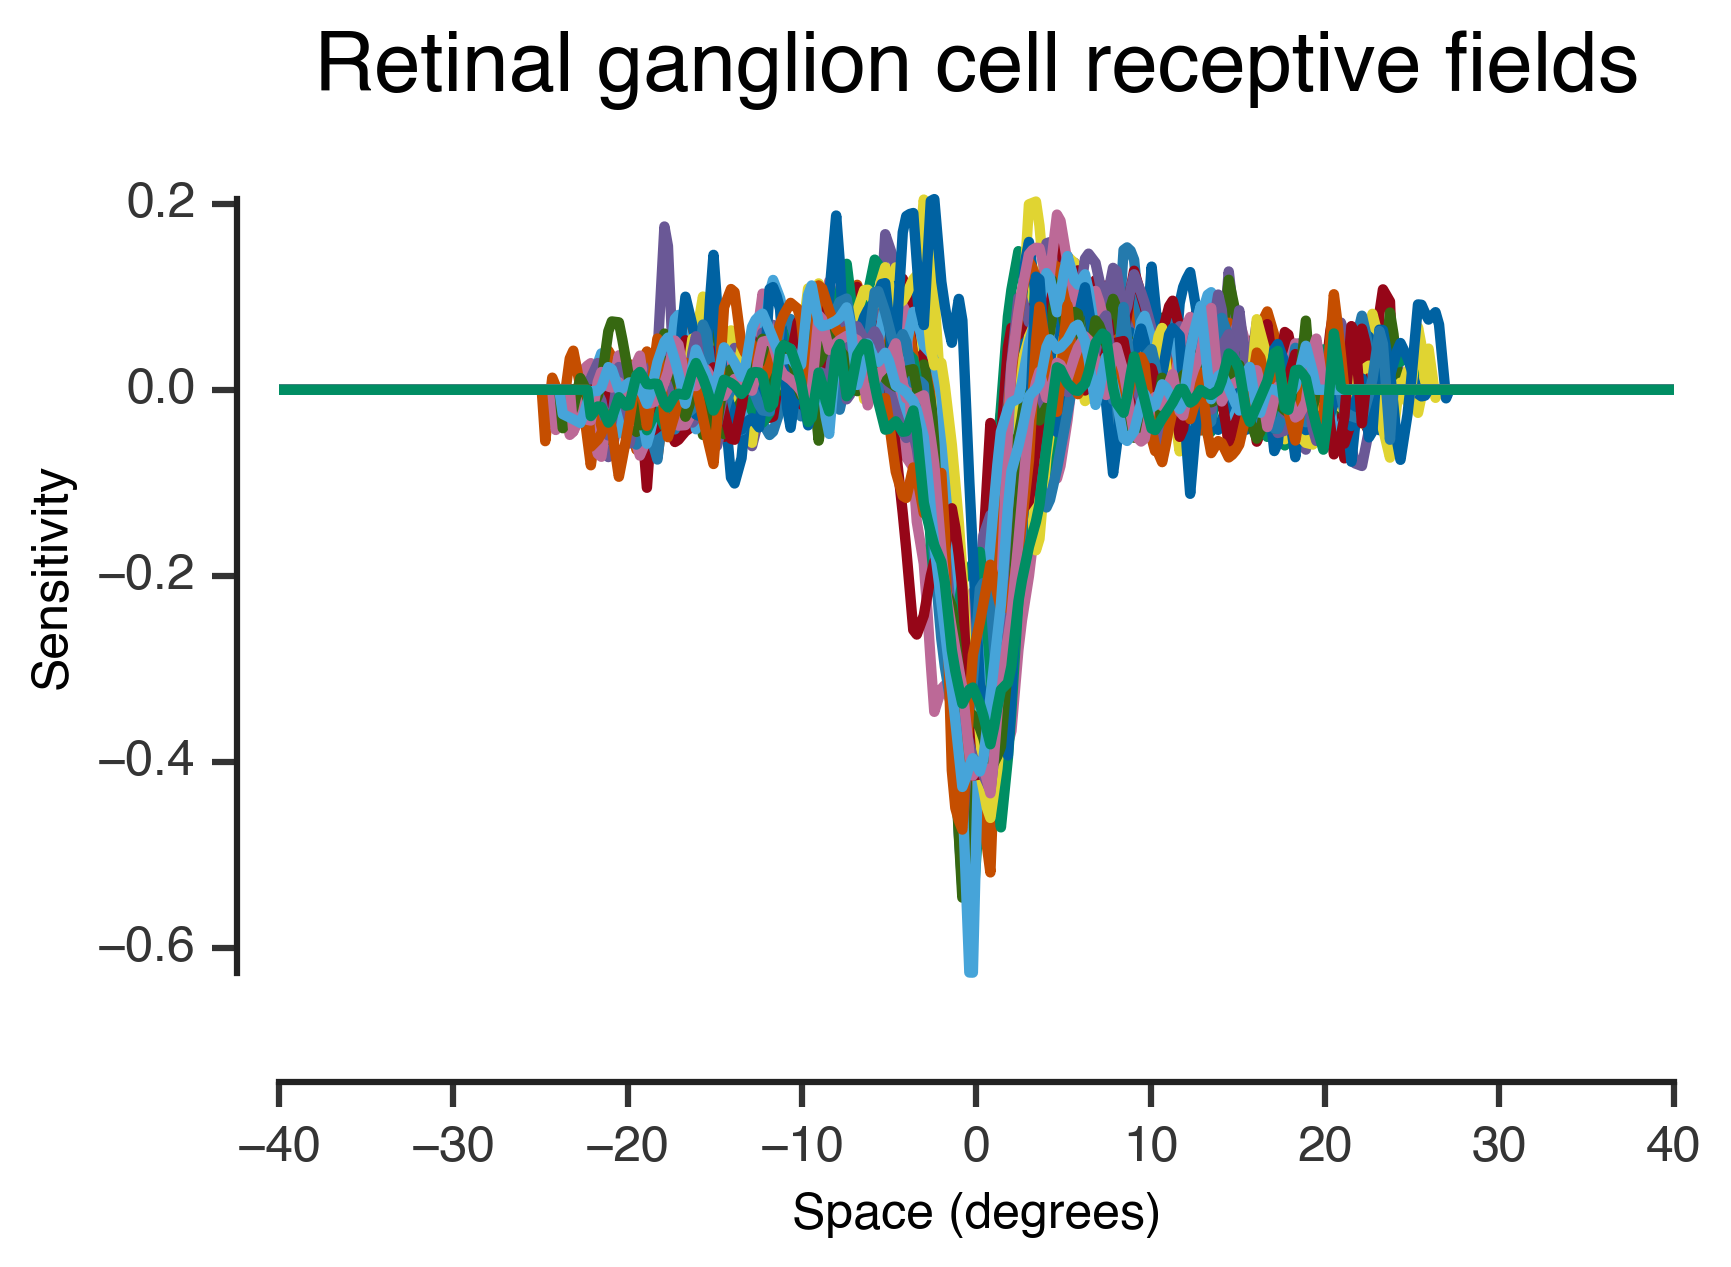

In [49]:
for c in receptive_fields['ganglion']:
    plt.plot(space, c)
plt.xlabel('Space (degrees)')
plt.ylabel('Sensitivity')
plt.title('Retinal ganglion cell receptive fields')
adjust_spines(plt.gca())

Average retinal ganglion cell receptive field

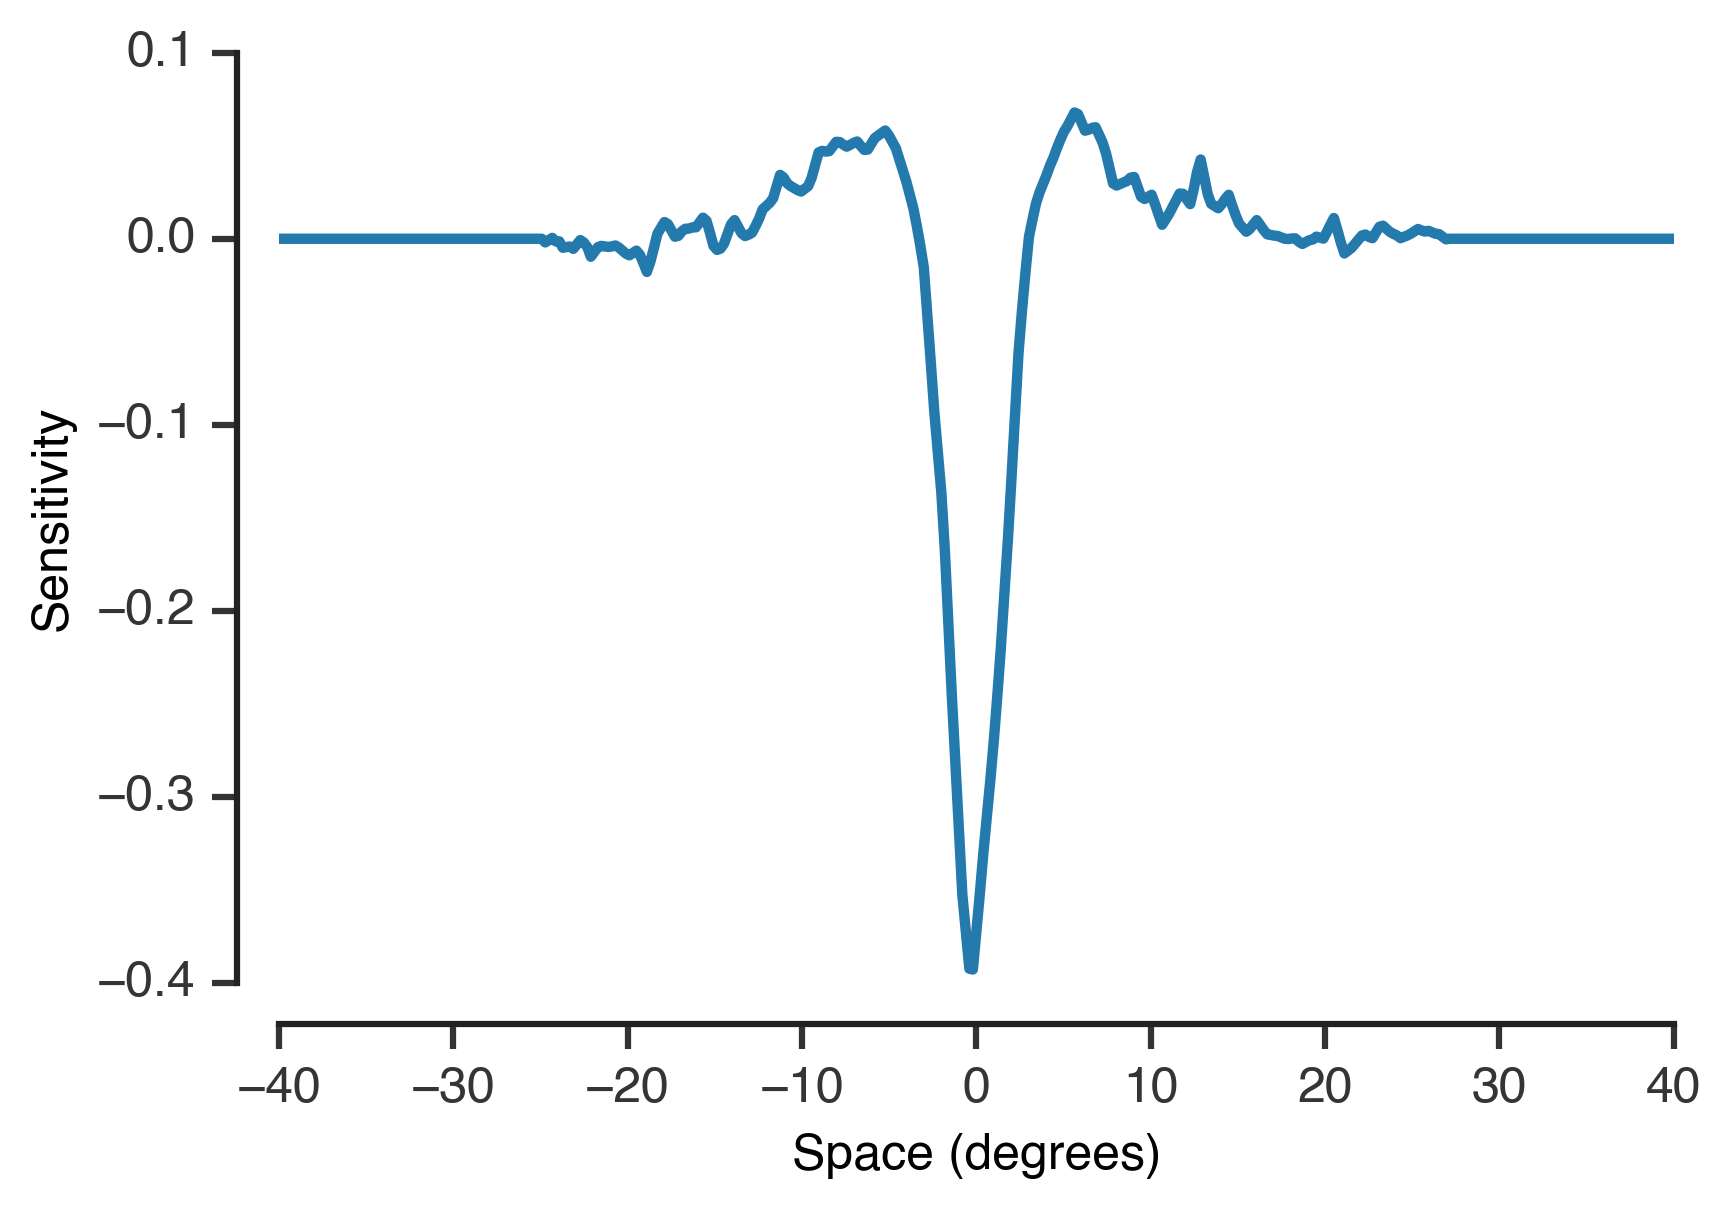

In [50]:
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)
plt.plot(space, average_ganglion_rf)
plt.ylabel('Sensitivity')
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

### Compute projective fields

In [51]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

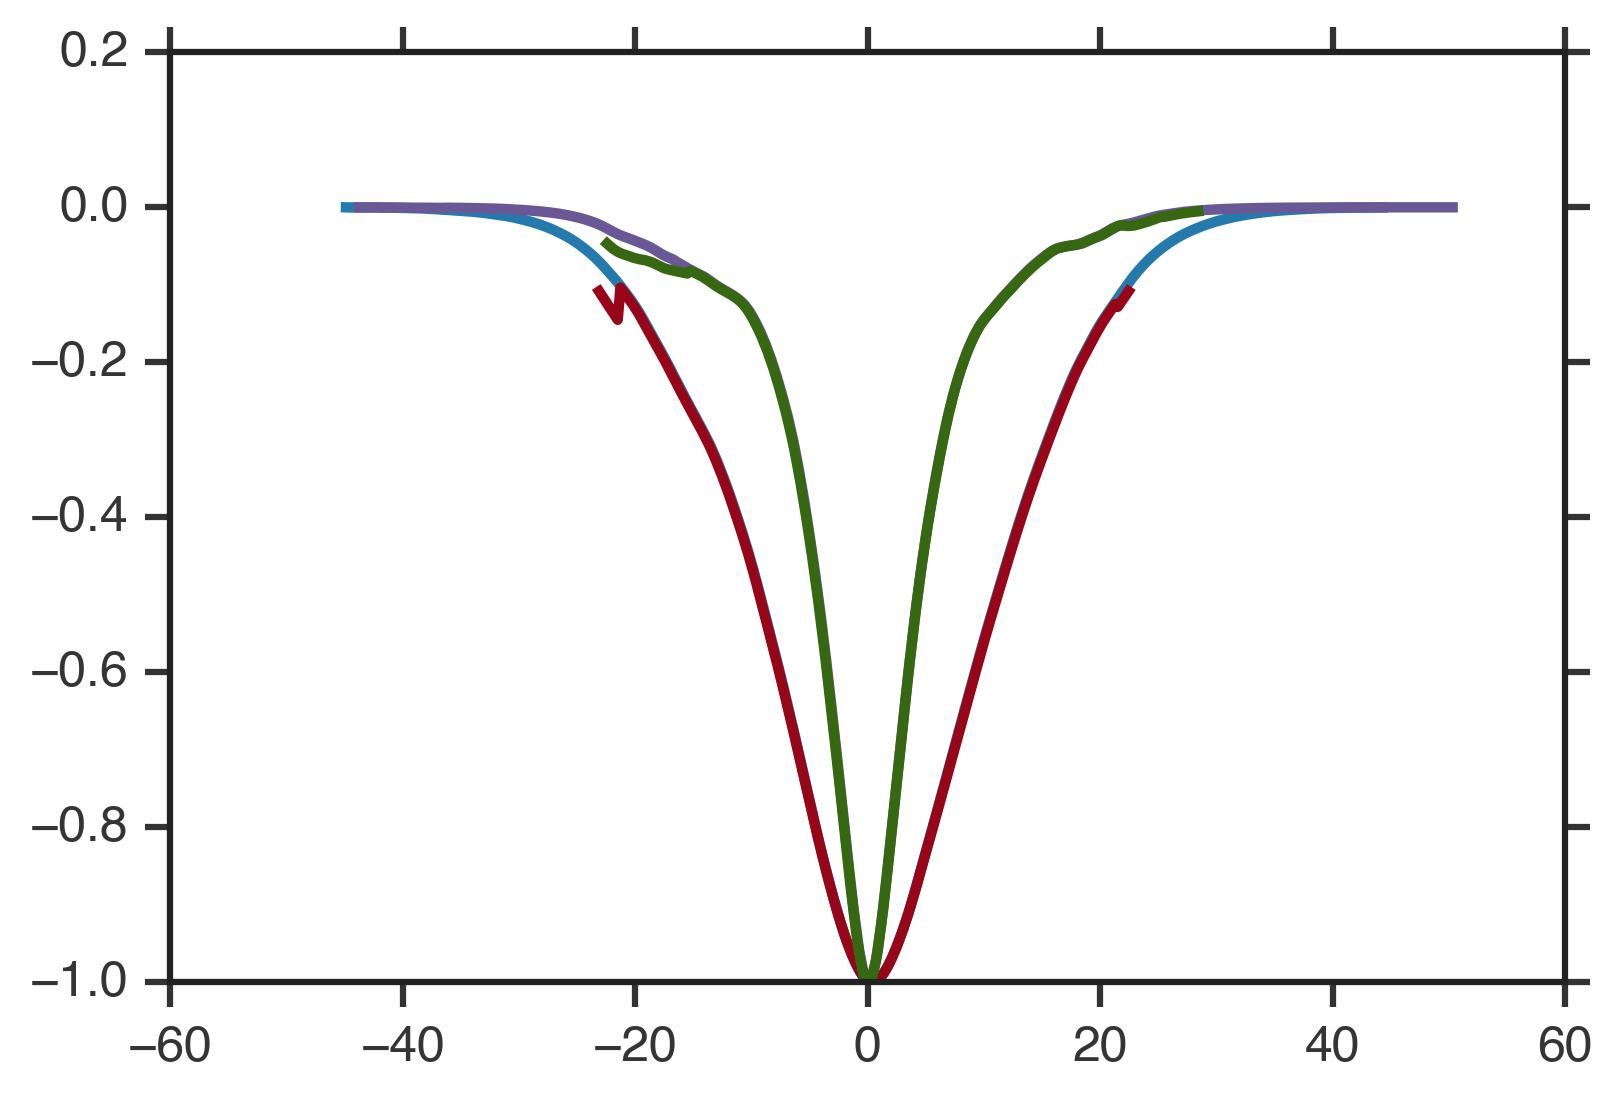

In [52]:
plt.plot(space_h_full, horz_pf_full/np.max(abs(horz_pf_full)))
plt.plot(space_h_same, horz_pf_same/np.max(abs(horz_pf_same)))
plt.plot(space_a_full, ama_pf_full/np.max(abs(ama_pf_full)))
plt.plot(space_a_same, ama_pf_same/np.max(abs(ama_pf_same)))

In [53]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

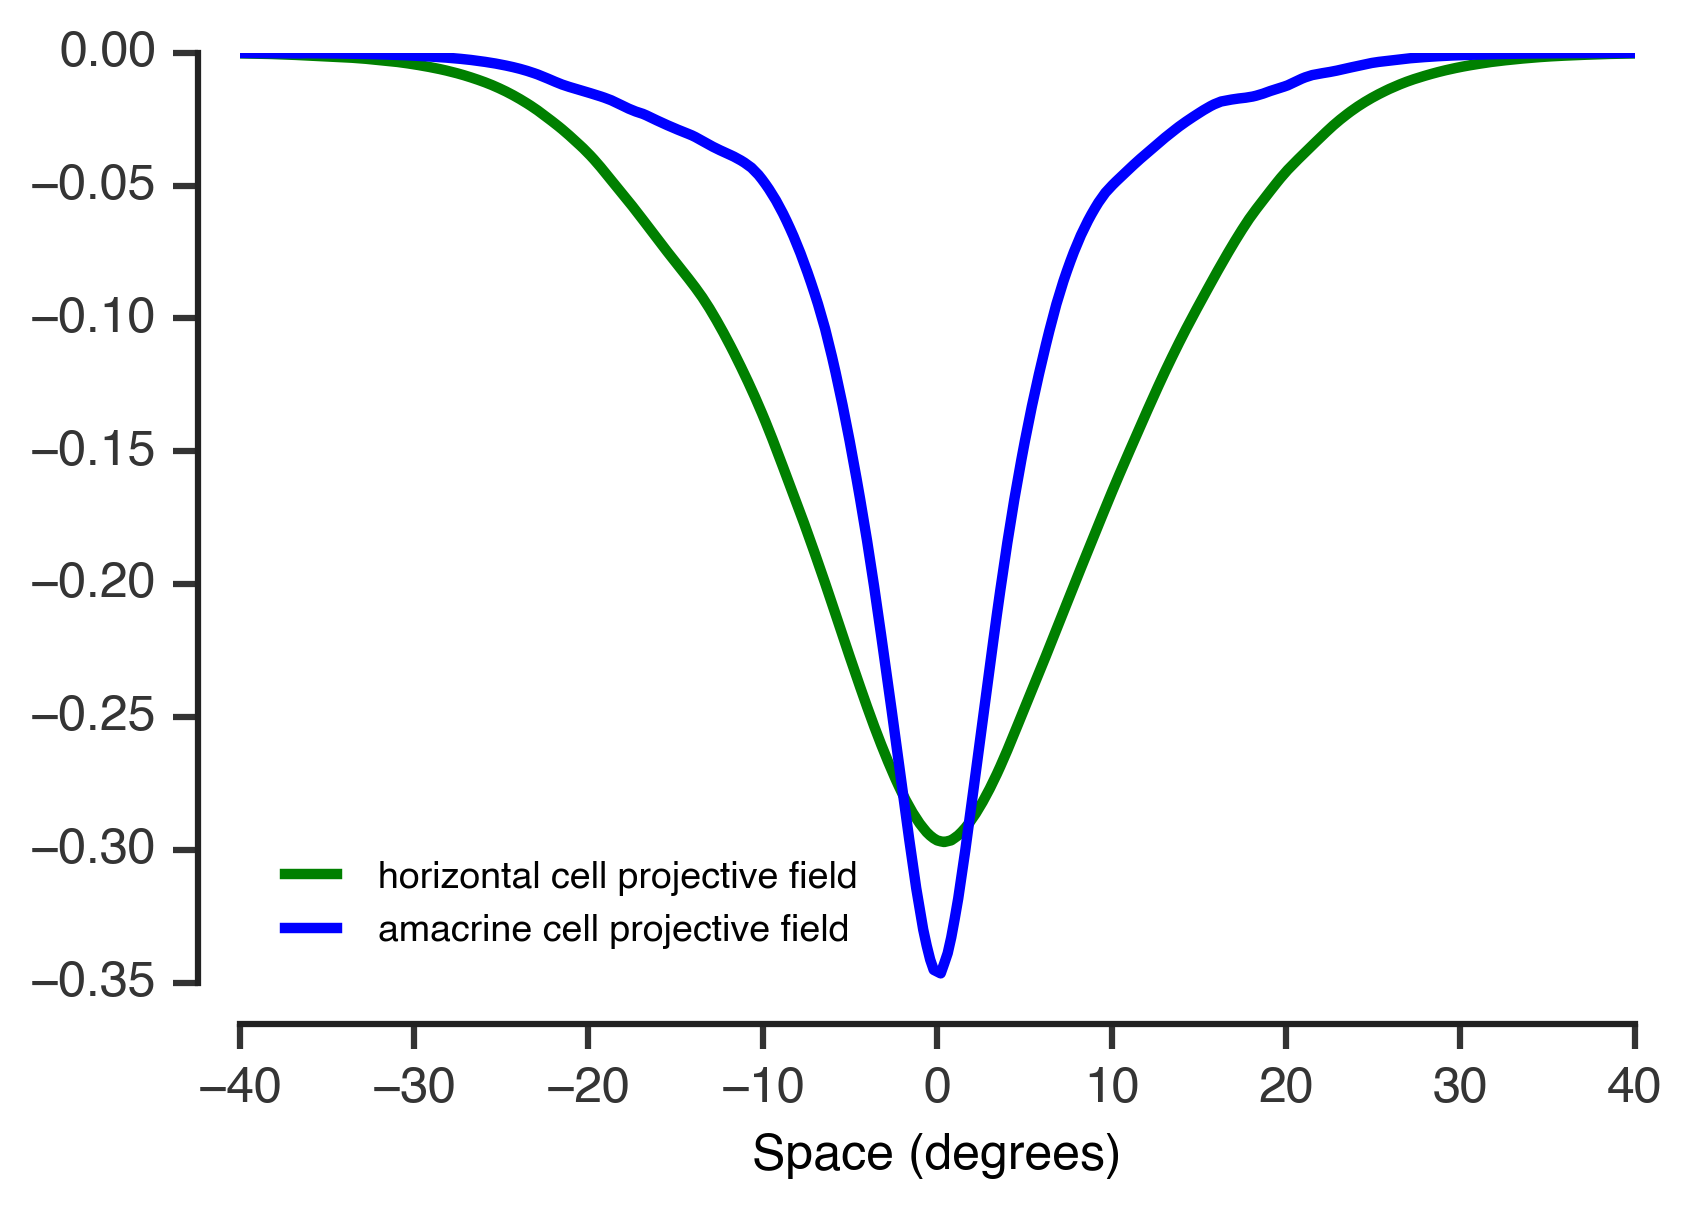

In [54]:
plt.plot(space, horz_pf, 'g', label='horizontal cell projective field')
plt.plot(space, ama_pf, 'b', label='amacrine cell projective field')
plt.legend(frameon=False, fontsize=9, loc='lower left')
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

### Signal

In [14]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [15]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


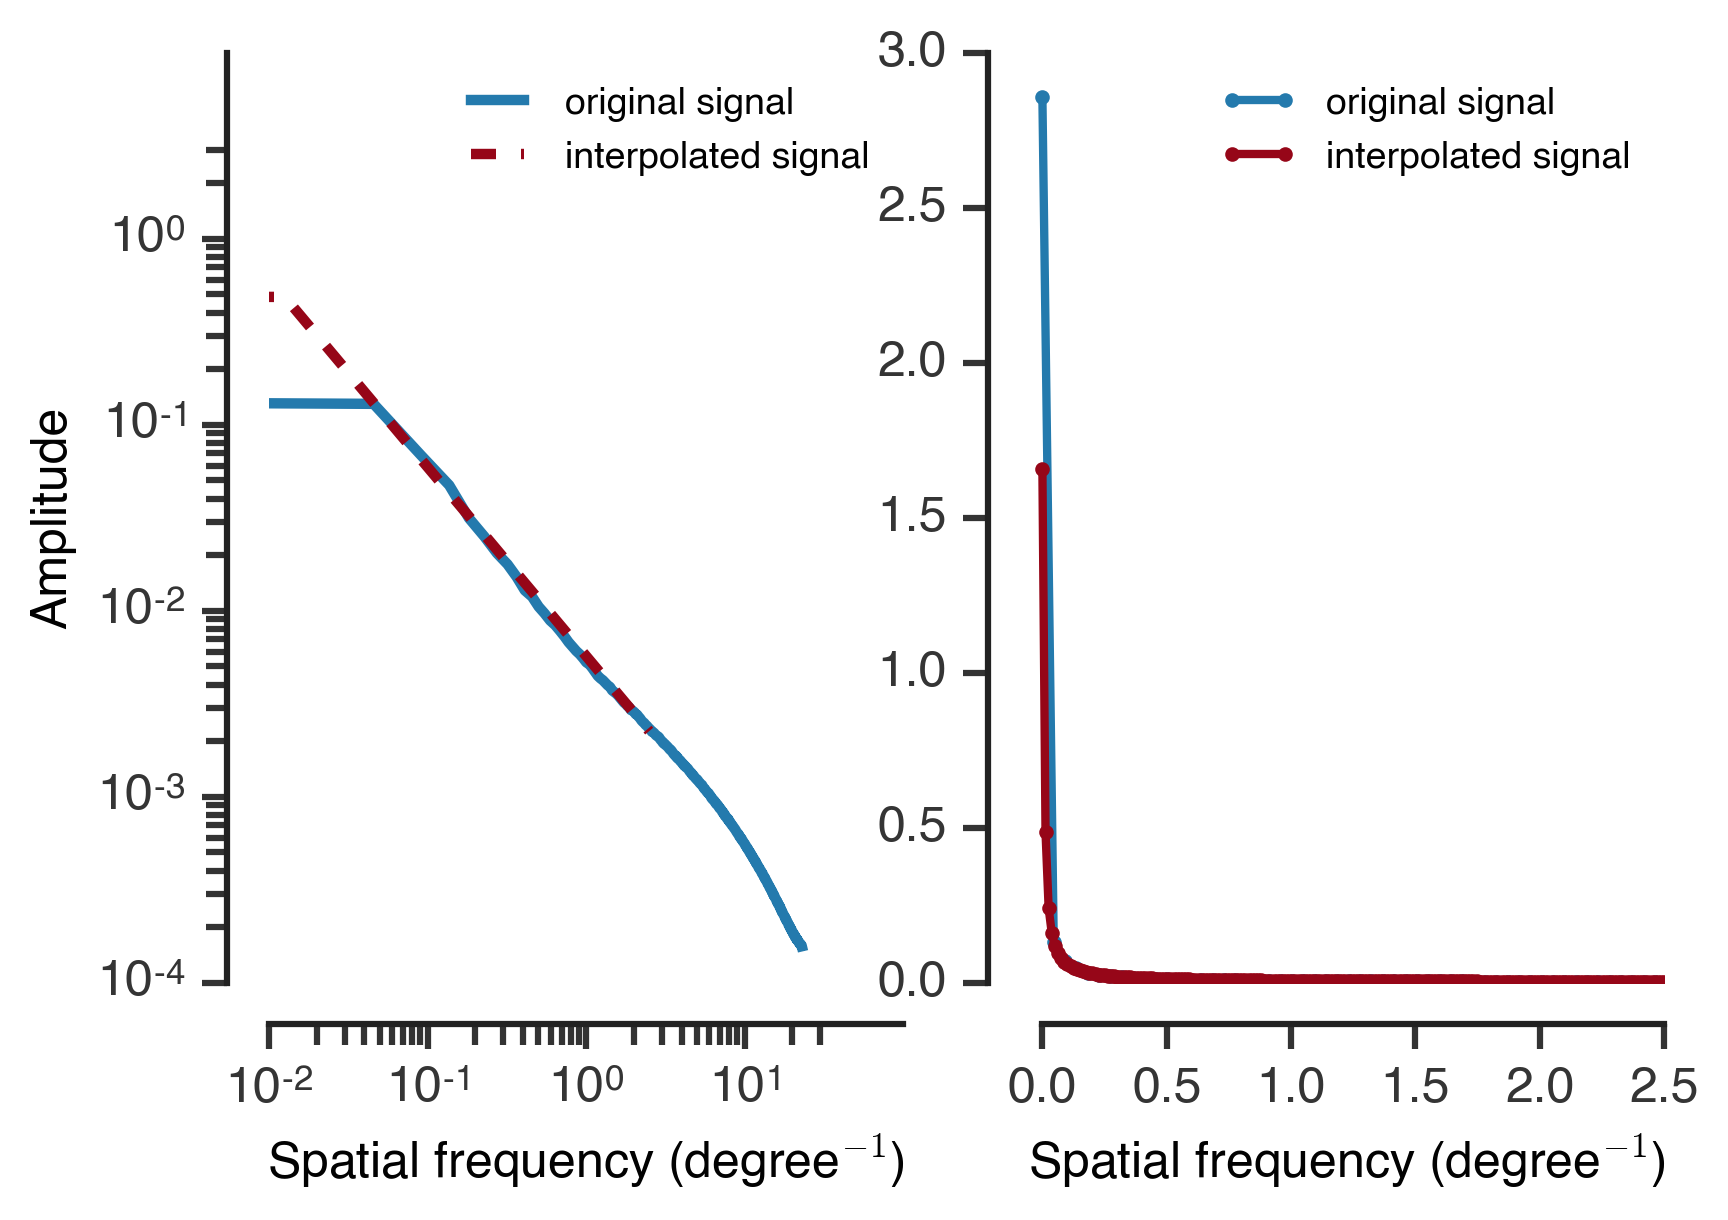

In [55]:
plt.subplot(121)
plt.plot(signal_freqs, signal_amps, label='original signal')
plt.plot(freqs, signal, '--', label='interpolated signal')
plt.legend(frameon=False, fontsize=9)
plt.xscale('log')
plt.yscale('log')
adjust_spines(plt.gca())
plt.xlabel('Spatial frequency (degree$^{-1}$)')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.plot(signal_freqs, signal_amps, '.-', markersize=6, linewidth=2, label='original signal')
plt.plot(freqs, signal, '.-', markersize=6, linewidth=2, label='interpolated signal')
adjust_spines(plt.gca())
plt.xlim(-.05, 2.5)
# plt.ylim(-.05, 1.8)
plt.xlabel('Spatial frequency (degree$^{-1}$)')
# plt.ylabel('Amplitude')
plt.legend(frameon=False, fontsize=9)

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [56]:
input_noise = 0.1
output_noise = 0.35

1.87526954877


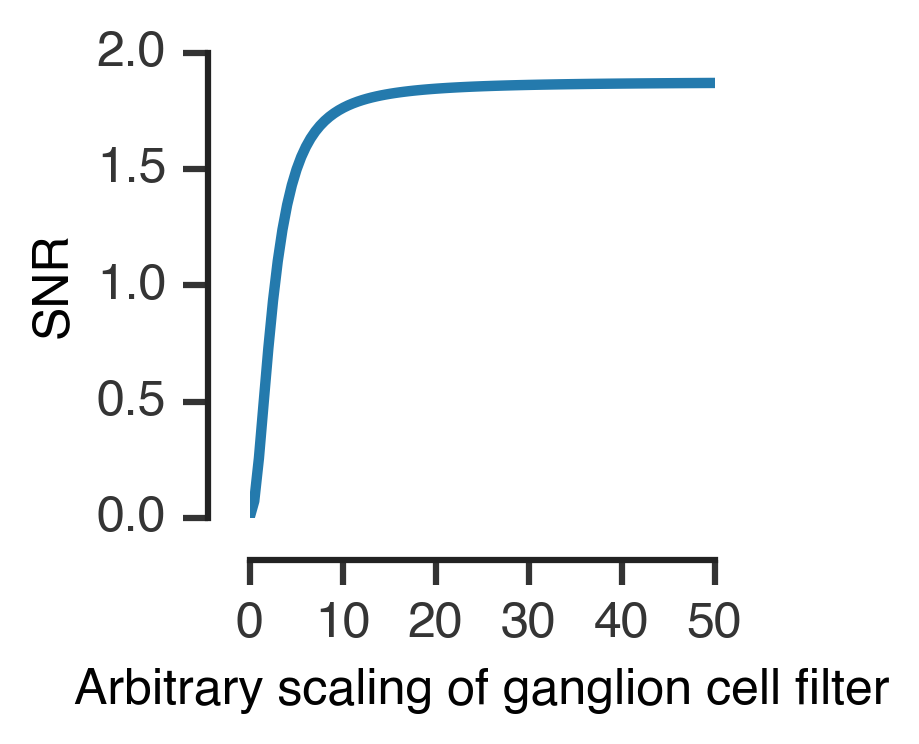

In [61]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

### Ideal filter

In [62]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 1.30824842815e-07.


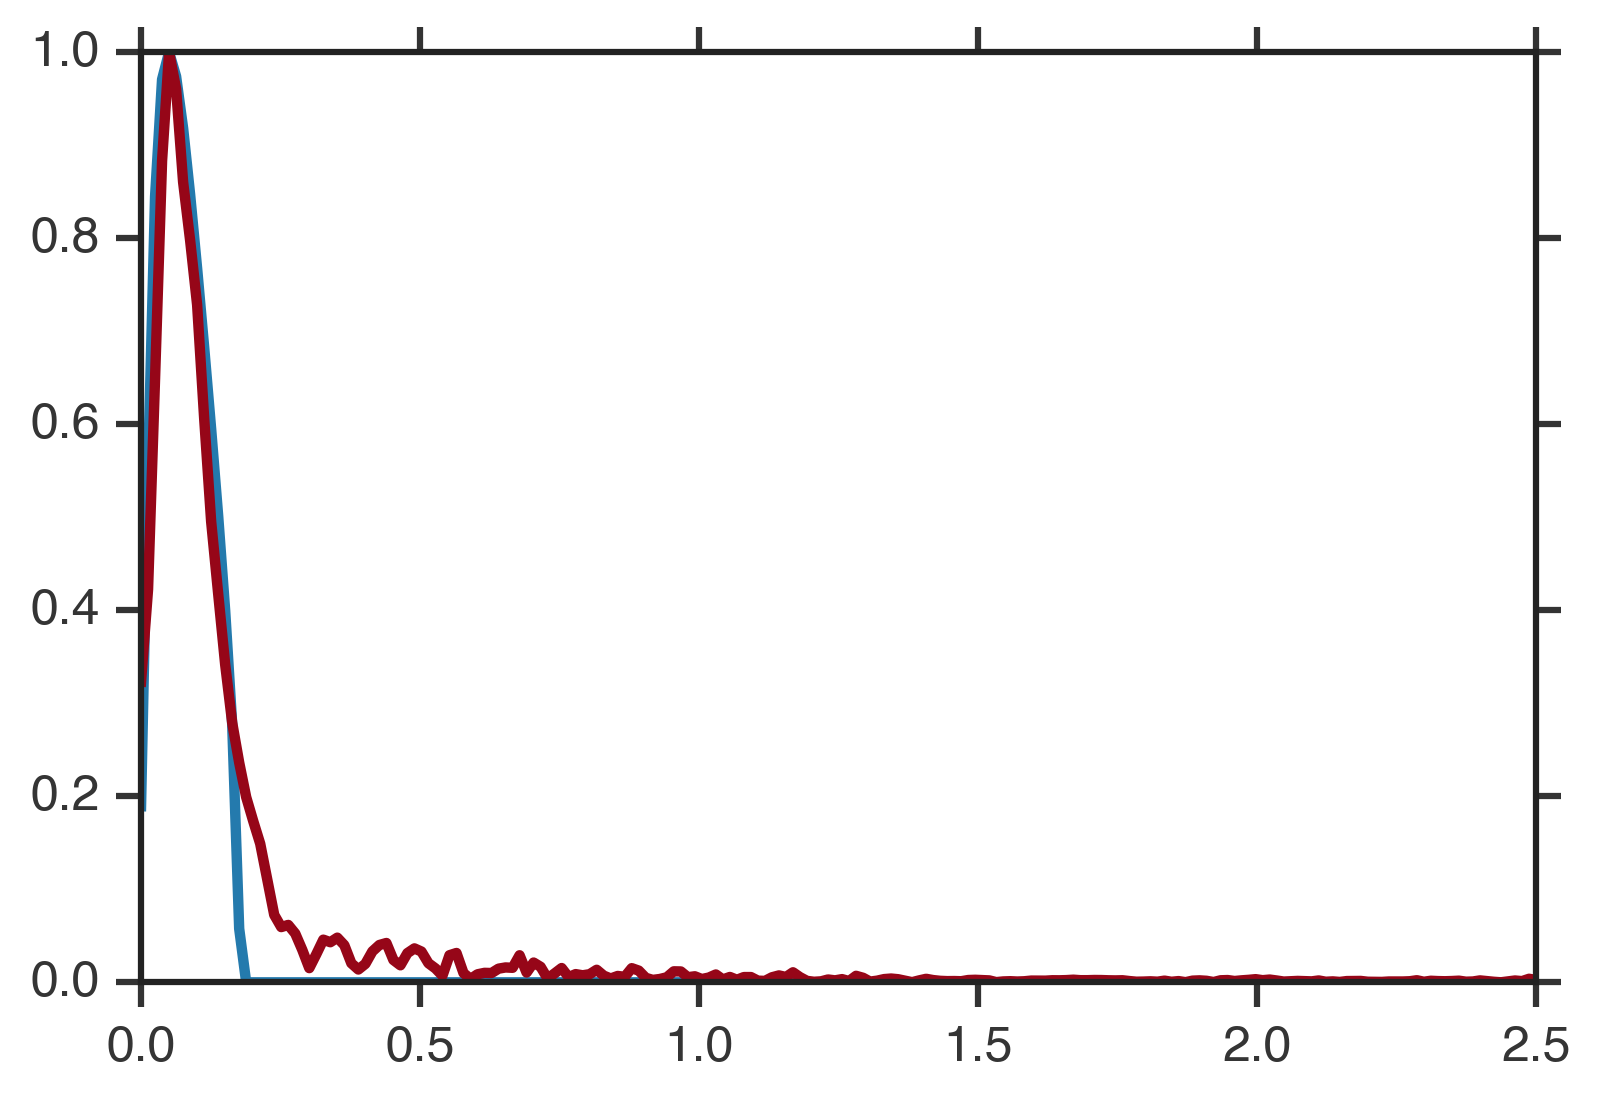

In [63]:
plt.plot(freqs, ideal_filter/np.max(ideal_filter))
plt.plot(freqs, average_ganglion_fft/np.max(average_ganglion_fft))

### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [64]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

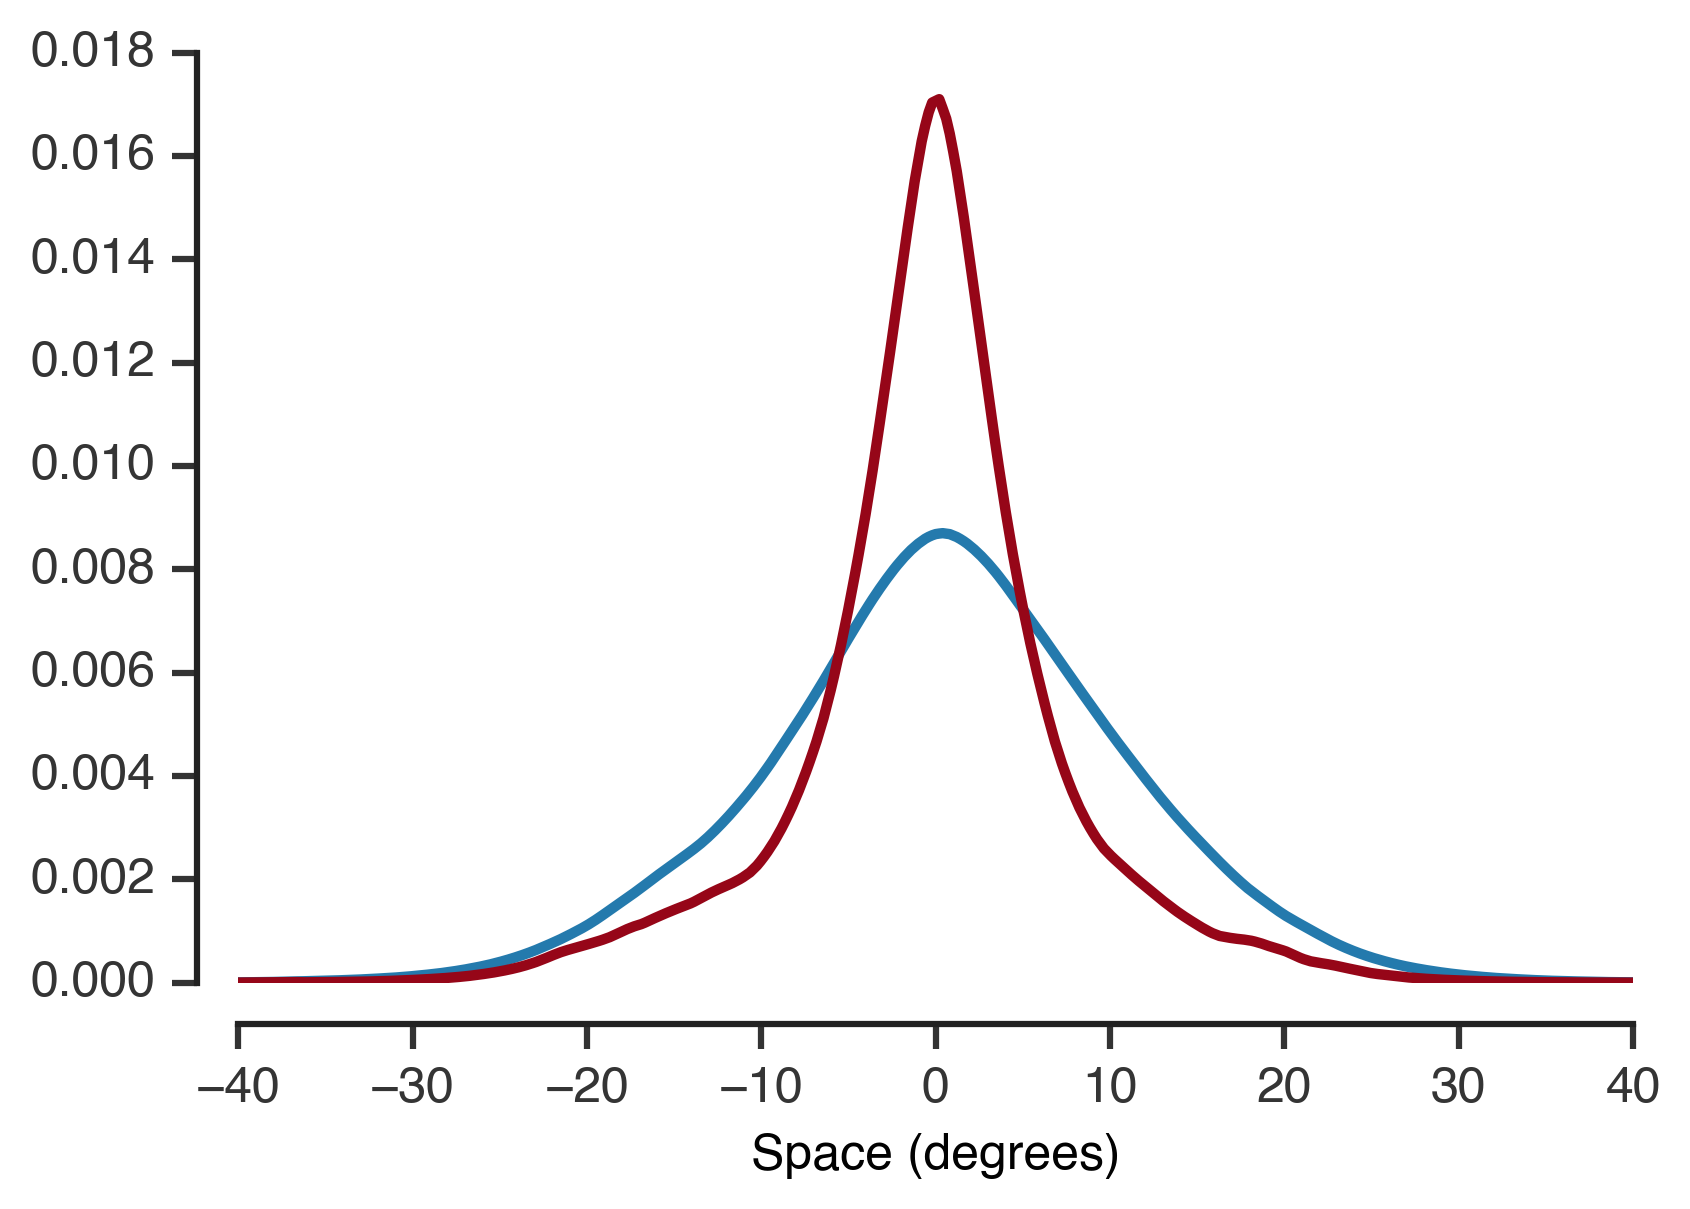

In [65]:
plt.plot(space, horz_pf)
plt.plot(space, ama_pf)
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

Load David's 1721 ganglion cells

In [66]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [67]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='area')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

Get center widths for each celltype

In [68]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [69]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [70]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

249it [01:03,  8.02it/s]
28it [00:05,  2.59it/s]
126it [00:59,  1.11s/it]
253it [01:13,  5.92it/s]
321it [00:54, 13.17it/s]
772it [01:22,  9.35it/s]


In [121]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 20 in fast_off_sensitizing
couldn't fit 2 in ganglion
couldn't fit 23 in fast_on
couldn't fit 14 in slow_off
couldn't fit 9 in medium_off_adapting
couldn't fit 8 in fast_off_adapting


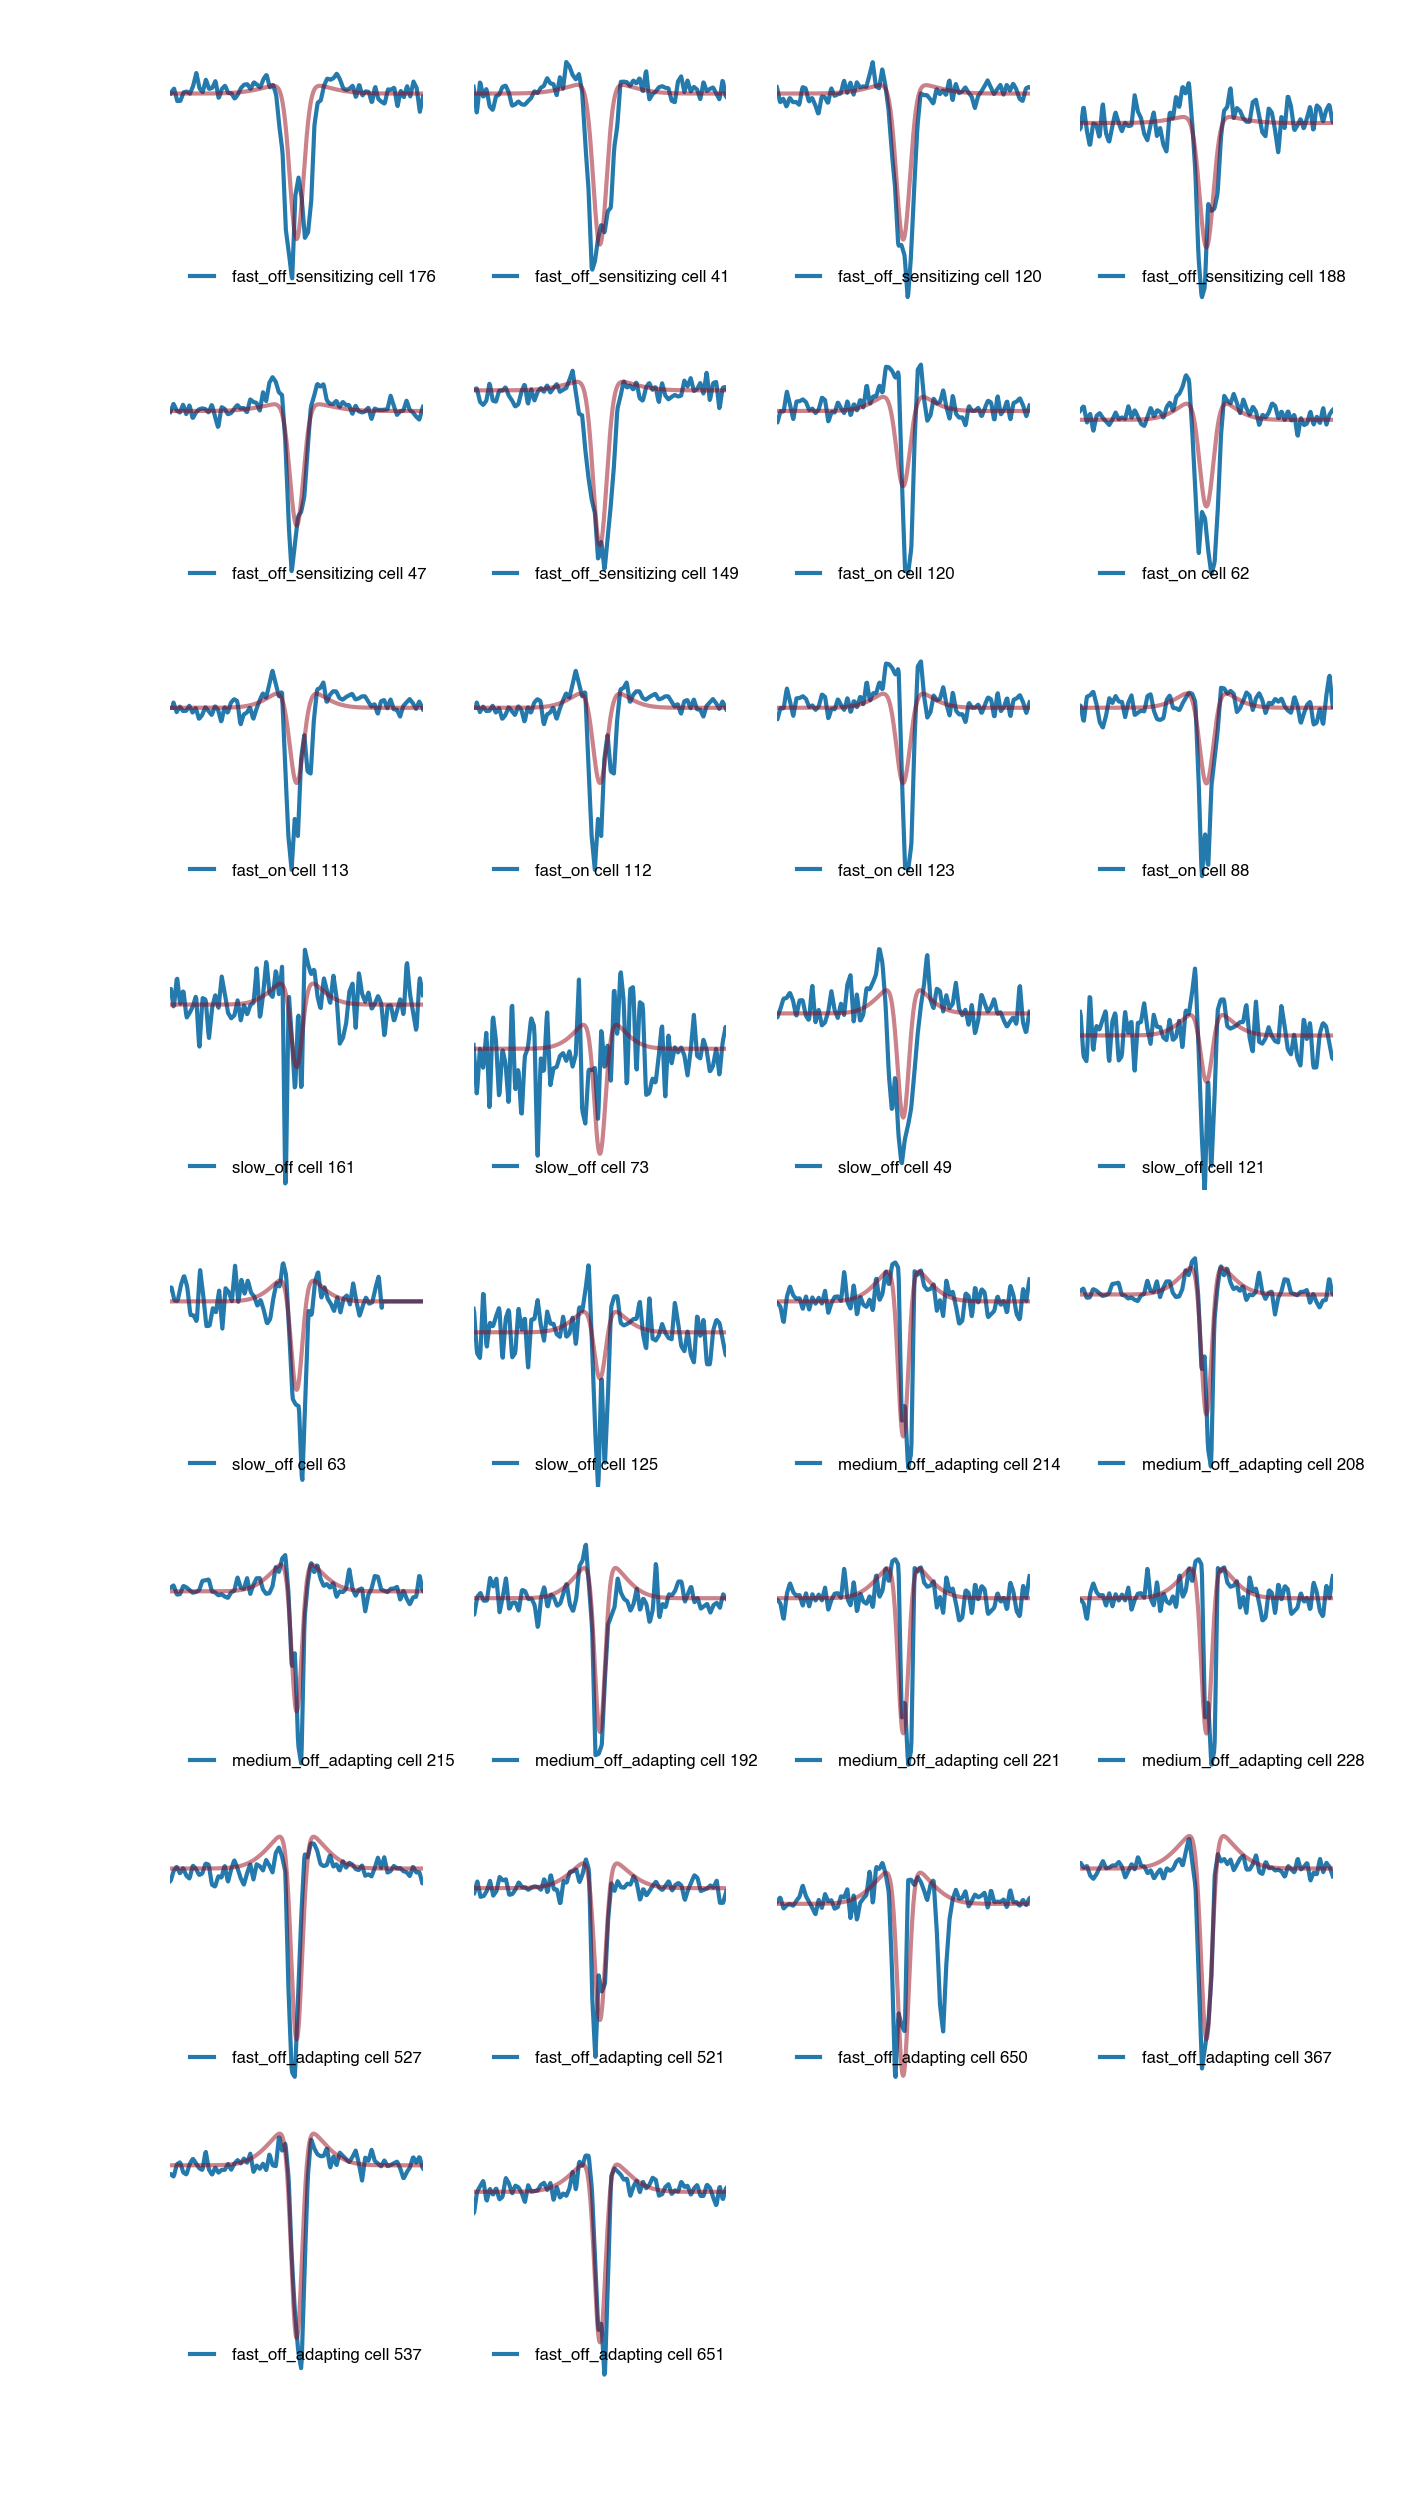

In [126]:
fig = plt.gcf()
fig.set_size_inches((5,10))
examples = 6
plot_id = 0
number_of_plots = examples * len([k for k in fit_failures.keys() if k not in ['ganglion']])
cols = 4
rows = number_of_plots//cols + 1
for celltype in fit_failures.keys():
    if celltype != 'ganglion':
        exs = np.random.choice(fit_failures[celltype], examples, replace=False)
        for idc in exs:
            plot_id += 1
            plt.subplot(rows, cols, plot_id)
            plt.plot(space, receptive_fields[celltype][idc], label='%s cell %d' %(celltype, idc),
                    linewidth=1)
            plt.plot(space, center_and_surround(space, center_widths[celltype][idc], surround_widths[celltype][idc],
                                               center_strengths[celltype][idc], surround_strengths[celltype][idc]),
                    linewidth=1, alpha=0.5)
            plt.legend(frameon=False, fontsize=4, loc='lower left')
            ax = plt.gca()
            ax.axis('off')
        

Plot the average profile across celltypes

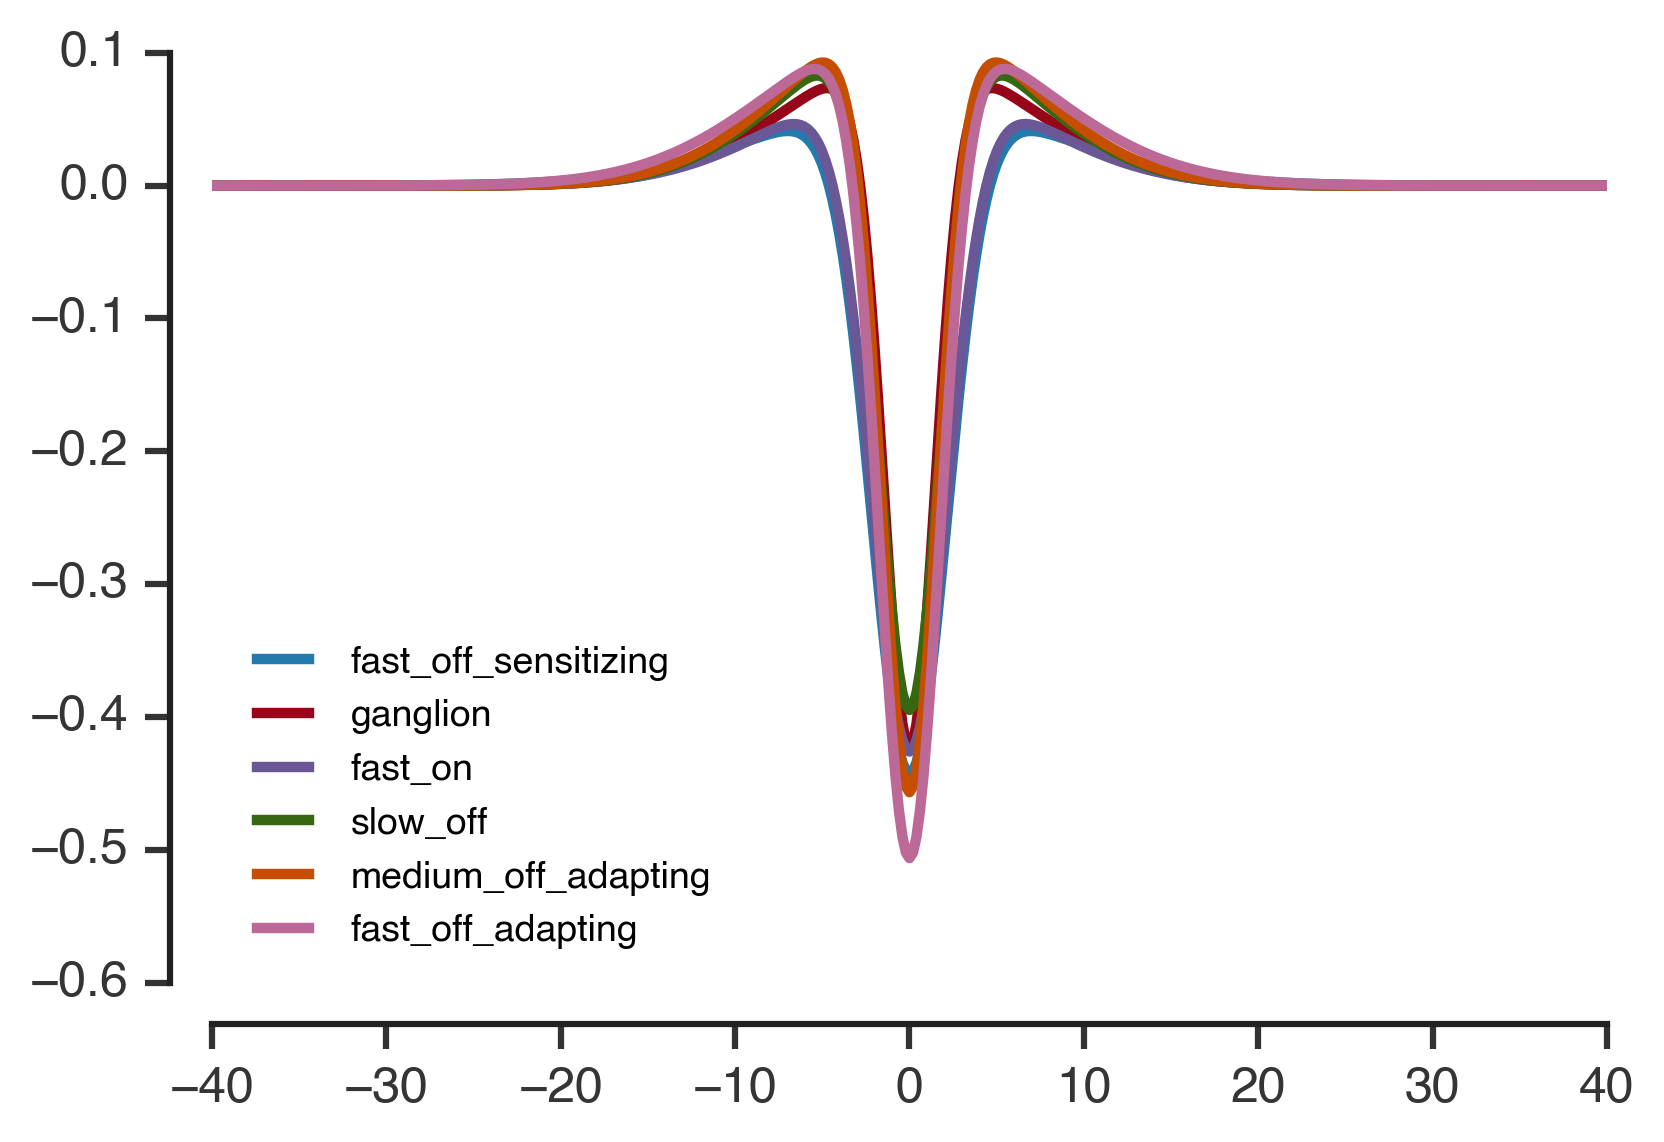

In [142]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
    plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
                                     median_center_strength, median_surround_strength), label=celltype)
plt.legend(frameon=False, fontsize=9, loc='lower left')
adjust_spines(plt.gca())

In [143]:
median_center_widths

{'fast_off_adapting': 1.7510409216950089,
 'fast_off_sensitizing': 2.1817845966243197,
 'fast_on': 2.1867229047283274,
 'ganglion': 1.5101001234083309,
 'medium_off_adapting': 1.6404347694277421,
 'slow_off': 1.7896452733111841}

Bar charts to visualize diversity

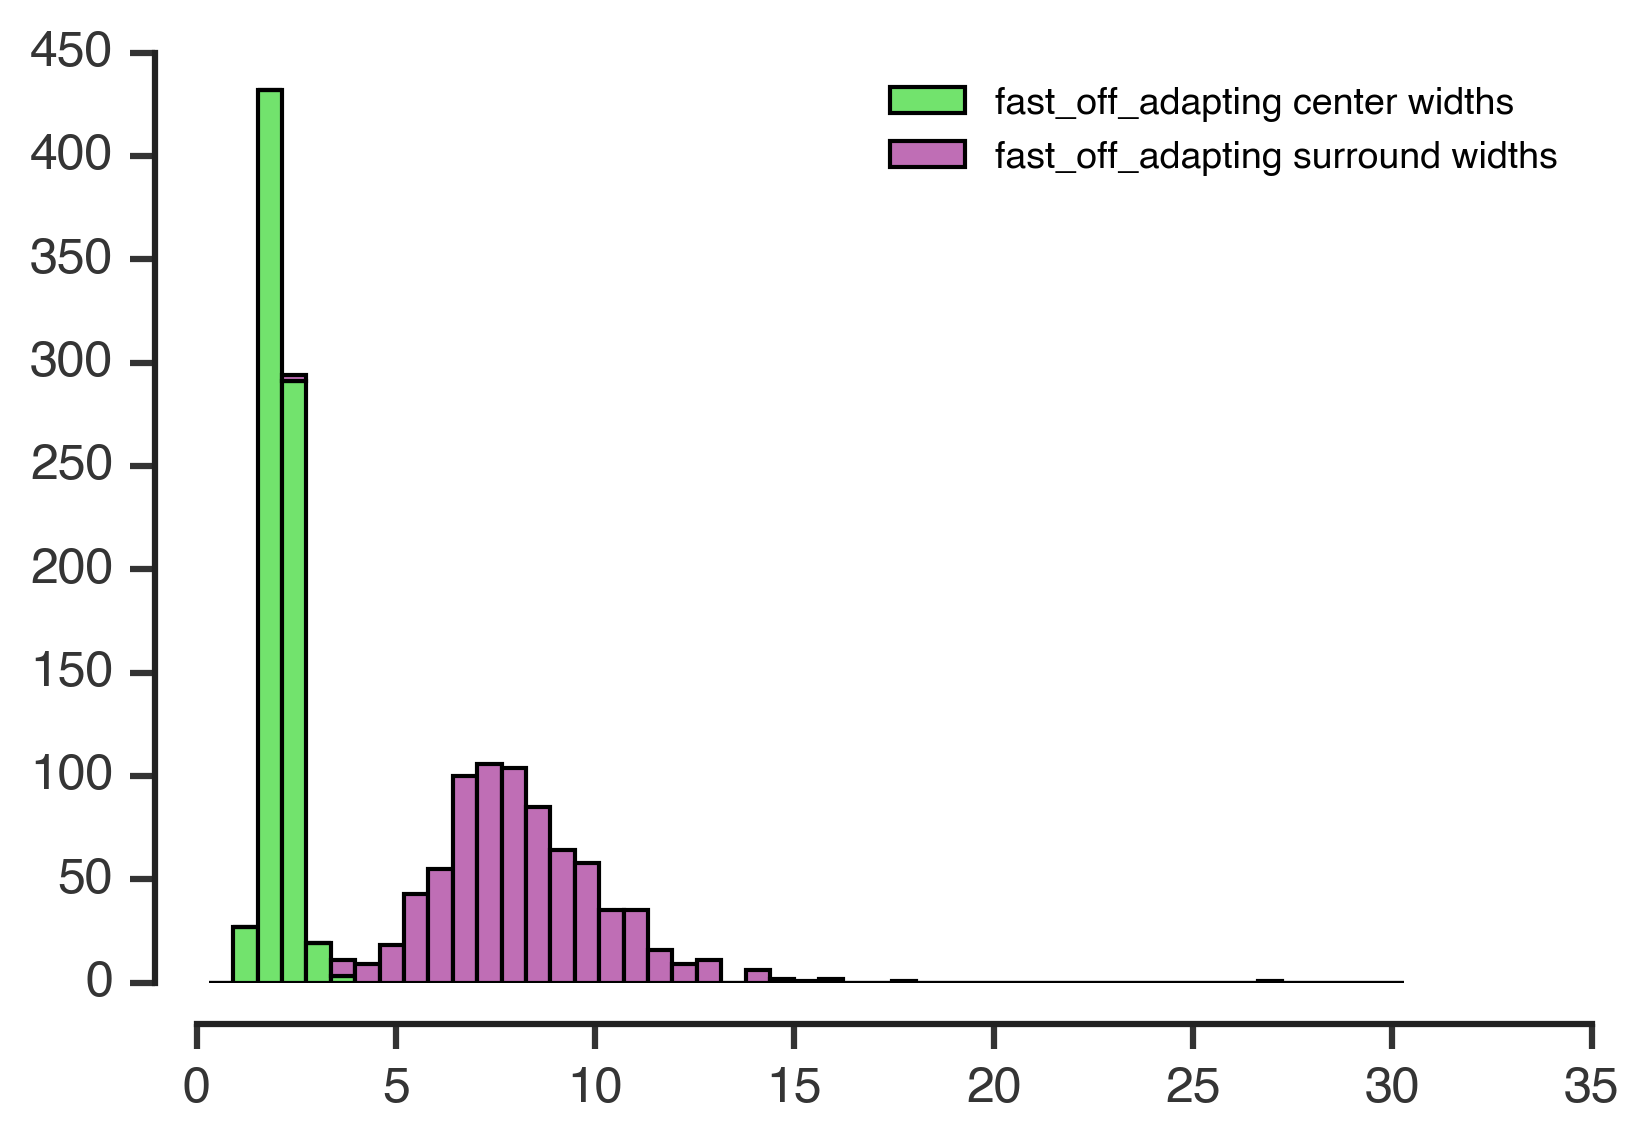

In [146]:
cws = np.array(center_widths[celltype])
sws = np.array(surround_widths[celltype])
# bins = np.linspace(np.min([cws]), np.max(sws[sws < 200]), 50)
bins = np.linspace(0,30,50)
counts, bins = np.histogram(cws[cws < 500], bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center widths' %celltype)

counts_surr, bins_surr = np.histogram(sws[sws < 500], bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround widths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

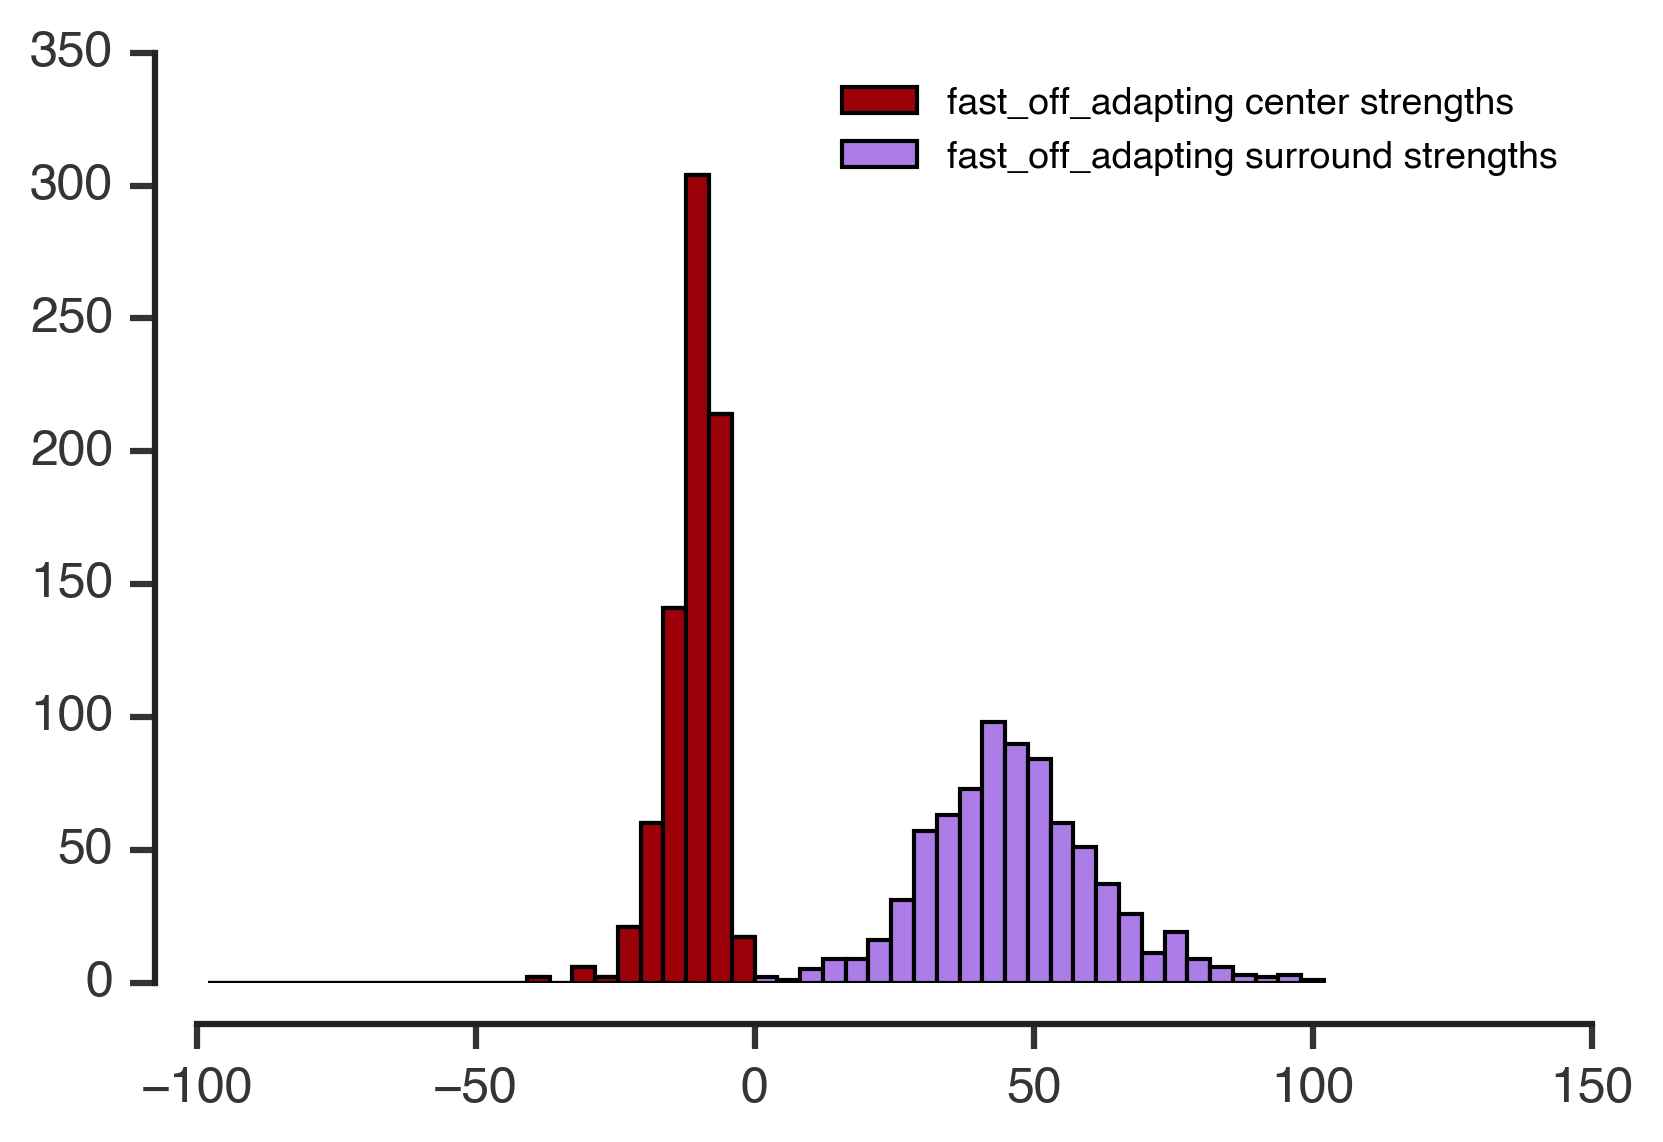

In [148]:
css = -abs(np.array(center_strengths[celltype]))
sss = abs(np.array(surround_strengths[celltype]))
# bins = np.linspace(np.min([css]), np.max(sss), 50)
bins = np.linspace(-100,100,50)
counts, bins = np.histogram(css, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center strengths' %celltype)

counts_surr, bins_surr = np.histogram(sss, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround strengths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

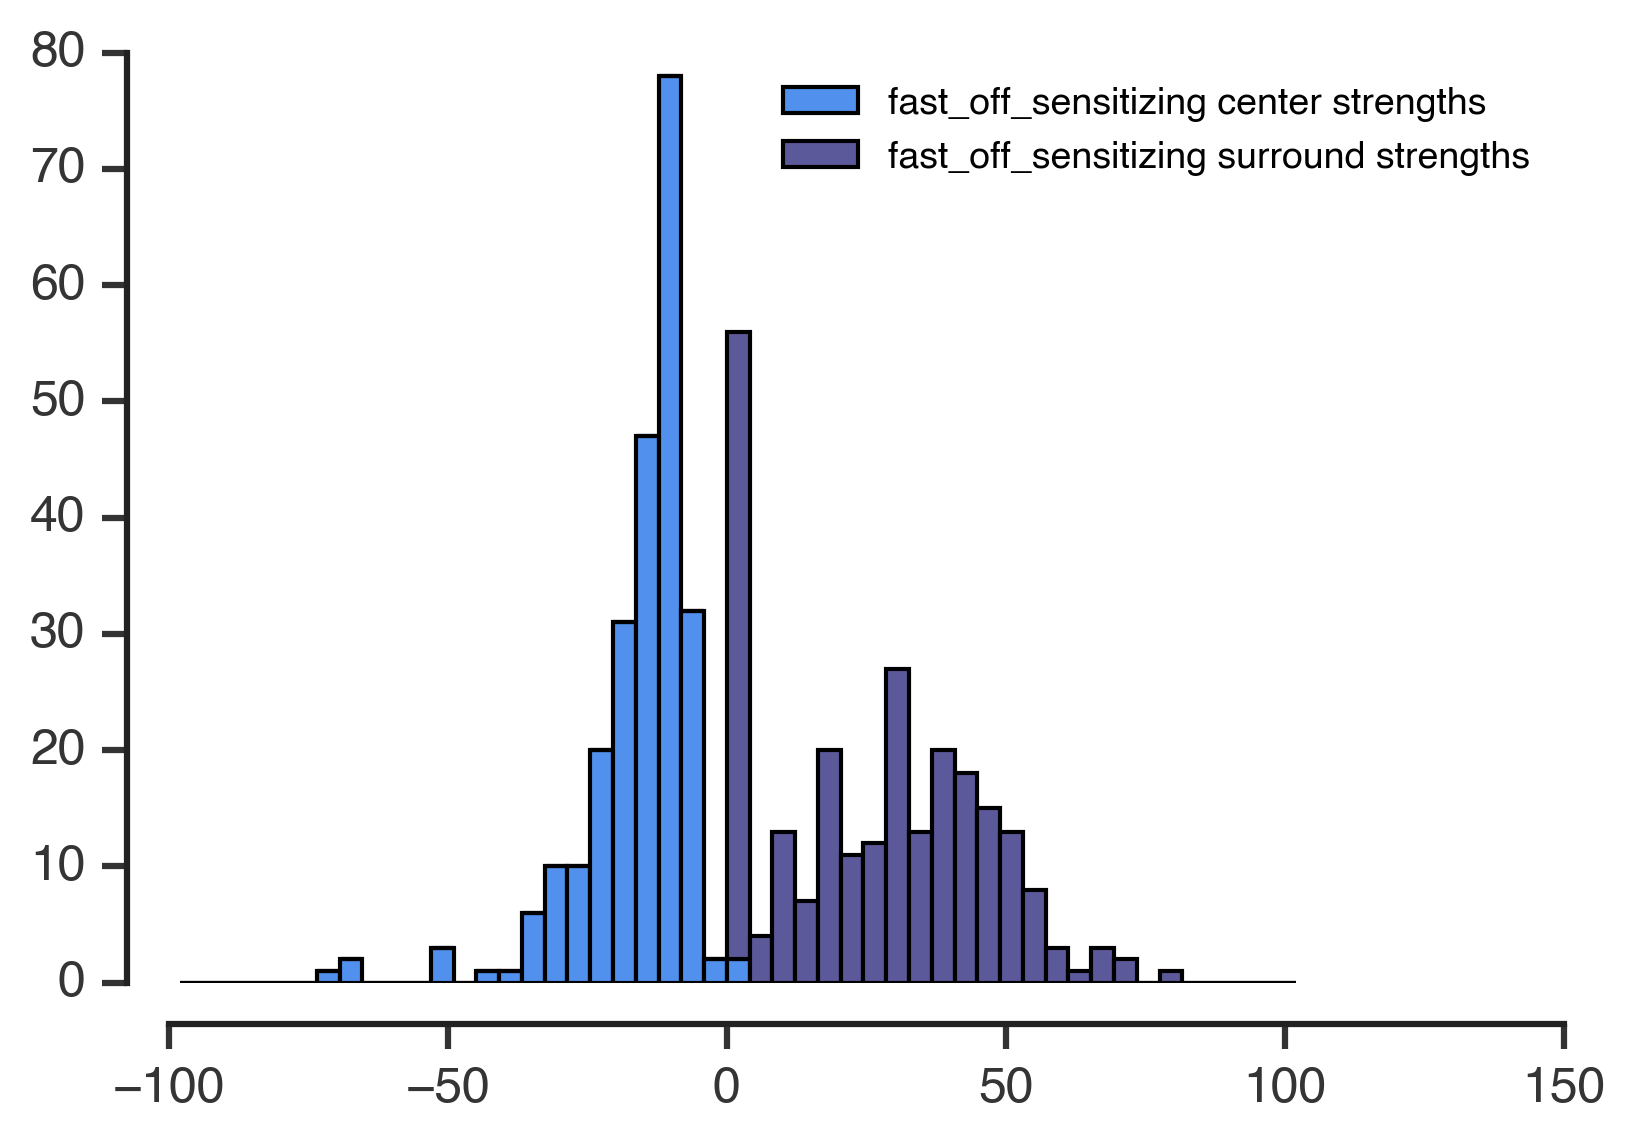

In [138]:
celltype = 'fast_off_sensitizing'
css = -abs(np.array(center_strengths[celltype]))
sss = abs(np.array(surround_strengths[celltype]))
# bins = np.linspace(np.min([css]), np.max(sss), 50)
bins = np.linspace(-100,100,50)
counts, bins = np.histogram(css, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center strengths' %celltype)

counts_surr, bins_surr = np.histogram(sss, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround strengths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

## Run info maps

In [140]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [141]:
target_power = 5e1
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

150it [00:27,  5.41it/s]
150it [00:27,  5.45it/s]
150it [00:27,  5.42it/s]
150it [00:27,  5.46it/s]
150it [00:27,  5.46it/s]
150it [00:27,  5.45it/s]


## Fit cells to rf_model

In [ ]:
iterations = 100

fits = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):
            center = gaussian(x=space, sigma=center_widths[celltype][i], mu=0.)
            center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

            def rf_model(horz_weight, center_weight):
                horz_weight = np.min([1.0, abs(horz_weight)])
                center_weight = np.min([1.0, abs(center_weight)])
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
            
            def model_error_to_ganglion_cells(weights):
                hw, cw = weights
                modeled_rf = rf_model(hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf))

            best_fit_err = np.inf
            for itr in range(iterations):
                this_popt = minimize(model_error_to_ganglion_cells, np.random.rand(2))
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            x = np.where(abs(popt.x) > 1, 1, abs(popt.x))

            popts.append(x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)

249it [03:03,  1.32it/s]
28it [00:33,  1.20s/it]
126it [01:49,  1.15it/s]
57it [01:02,  1.10s/it]

In [ ]:
rel_error = np.array(mean_squared_errors['fast_off_adapting'])/np.array(variances['fast_off_adapting'])
count, bins = np.histogram(rel_error, 50)
bin_width = np.mean(np.diff(bins))
plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=np.random.rand(3))

## Difference in information slopes at different horizontal, amacrine weightings

In [ ]:
plt.plot(center_weights, info_maps['ganglion'][0, :], label='hw %0.2f' %horz_weights[0])
plt.plot(center_weights, info_maps['ganglion'][75, :], label='hw %0.2f' %horz_weights[75])
plt.plot(center_weights, info_maps['ganglion'][149, :], label='hw %0.2f' %horz_weights[149])
plt.xlabel('Center (1 - surround) weight')
plt.ylabel('Information (bits)')
adjust_spines(plt.gca())
plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.ylim(4.5, 9.5)

## Cells on curves for different info maps

In [ ]:
colorscheme = 'rbgyck'
for c, celltype in enumerate(fits.keys()):
    plt.plot(center_weights, info_maps[celltype][75, :], alpha=0.8, color=colorscheme[c])
    infos_at_horz_slice = []
    center_weight_fits = np.stack(fits[celltype])[:, 1]
    for f in fits[celltype]:
        idx = np.argmin(abs(f[0] - horz_weights))
        idy = np.argmin(abs(f[1] - center_weights))
        infos_at_horz_slice.append(info_maps[celltype][idx, idy])

#     color = np.random.rand(3)
    plt.scatter(center_weight_fits, infos_at_horz_slice, color=colorscheme[c], label=celltype, s=30, 
                edgecolor='w', lw=0.5)
    plt.vlines(np.median(center_weight_fits), 5, 10, color=colorscheme[c], linestyle='--', alpha=0.8)
    

plt.legend(frameon=False, fontsize=9, loc='upper left')
plt.xlabel('Center (1 - surround) weight')
adjust_spines(plt.gca())
plt.ylim(4.5, 9.8)

In [ ]:
max_info = np.max([np.max(info_maps[key]) for key in info_maps.keys()])
min_info = np.min([np.min(info_maps[key]) for key in info_maps.keys()])
# min_info = 6
colorscheme = 'rbgyck'
for idc,celltype in enumerate(info_maps.keys()):
    plt.subplot('32%d' %(idc+1))
    plt.imshow(info_maps[celltype], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
#     plt.vlines(0.5, 0, 1, linewidth=1, linestyle='--', alpha=0.5)
#     plt.title('Total information of %s models' %celltype)
    plt.title(celltype, fontsize=9)
    if idc in [4,5]:
        plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=9)
    if idc == 2:
        plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=9)
    if idc % 2 == 1:
        plt.colorbar()
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if idc % 2 == 1:
        ax.spines['left'].set_visible(False)
        plt.yticks([])
        if idc == 5:
            ax.xaxis.set_ticks_position('bottom')
            plt.xticks([0,0.25,.5,.75,1])
        else:
            plt.xticks([])
    if idc % 2 == 0:
        ax.yaxis.set_ticks_position('left')
        if idc == 4:
            ax.xaxis.set_ticks_position('bottom')
            plt.xticks([0,0.25,.5,.75,1])
        else:
            plt.xticks([])
            
    plt.scatter(fits[celltype][:,1], fits[celltype][:,0],
                c=colorscheme[idc], edgecolor='w', s=10, alpha=0.5, label=celltype)

In [ ]:
plt.imshow(info_maps['ganglion'], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
plt.colorbar()
for celltype in info_maps.keys():
    plt.scatter(fits[celltype][:,1], fits[celltype][:,0],
                c=colorscheme[idc], edgecolor='w', s=10, alpha=0.5, label=celltype)

l = plt.legend(loc='upper left', frameon=False, fontsize=10)
for text in l.get_texts():
    text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])
plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.savefig('information_and_ganglion_cells_v2.pdf')